In [2]:
%matplotlib inline

import sys
#sys.path.append('/storage2/andrey/code/vrAnalysis/')
sys.path.append('/home/sobolev/storage2/andrey/code/vrAnalysis/')

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
from scipy import stats
from scipy import stats as scipystats

from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs, get_lonely_fields

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Get sessions

In [6]:
COLORS = get_colors()

#storage_path = '/home/andrey/storage2'
storage_path = '/storage2'
storage_path = '/home/sobolev/storage2'

source = os.path.join(storage_path, 'andrey/data/processed')
assets = os.path.join(storage_path, 'andrey/data/projects/24_shift/assets')
paper =  os.path.join(storage_path, 'andrey/data/projects/24_shift/PAPER')
bad_clu_dir = os.path.join(storage_path, 'andrey/data/projects/24_shift/bad_clusters')

animals = ['003281', '003282', '003908', '003909', '005363', '005364']
#animals = ['005363', '005364']
#animals = ['003281', '003282']
#animals = ['003909', '003908']
#animals = ['003281', '003282', '003909', '005363', '005364']  #  exclude '003908' as low quality

In [7]:
s_list_l = get_sessions_list(source, animals, 'SHIFT visual')
s_list_d = get_sessions_list(source, animals, 'SHIFT visual +dark')
s_list_long = get_sessions_list(source, animals, 'SHIFT visual long +dark')

s_list_all = list(s_list_l) + list(s_list_d)

len(s_list_l), len(s_list_d), len(s_list_long), len(s_list_all)

(7, 22, 16, 29)

In [5]:
# Just single sessions - LIGHT vs DARK
shift_A_B_short = get_fields_between_epochs(source, s_list_all, 'A', 'B')
#shift_A_B_dark = get_fields_between_epochs(source, s_list_d, 'A', 'B')
shift_A_D_short = get_fields_between_epochs(source, s_list_d, 'A', 'D')
shift_B_D_short = get_fields_between_epochs(source, s_list_d, 'B', 'D')

shift_A_B_long = get_fields_between_epochs(source, s_list_long, 'A', 'B')
shift_A_D_long = get_fields_between_epochs(source, s_list_long, 'A', 'D')
shift_B_D_long = get_fields_between_epochs(source, s_list_long, 'B', 'D')

# IMPORTANT!! Correct for VR ref frame - NO, don't correct
#shift_A_B['shift'] = shift_A_B['shift'] + 0.3

PF match found for 420 fields from total 801 A and 831 B fields
PF match found for 279 fields from total 513 A and 495 D fields
PF match found for 281 fields from total 527 B and 495 D fields
PF match found for 288 fields from total 516 A and 527 B fields
PF match found for 289 fields from total 516 A and 524 D fields
PF match found for 275 fields from total 527 B and 524 D fields


In [6]:
# lonely fields
lonely_A_B_short = pd.concat([get_lonely_fields(source, rec[0], rec[1], 'A', 'B') for rec in s_list_all])
lonely_A_B_long = pd.concat([get_lonely_fields(source, rec[0], rec[1], 'A', 'B') for rec in s_list_long])

In [7]:
print(list(shift_A_B_short))

['animal', 'session', 'electrode', 'unit', 'field_A', 'field_B', 'overlap_norm', 'sic_A', 'sic_B', 'isol_dist', 'peak_FR_A', 'peak_FR_B', 'COMa_x', 'COMa_y', 'COMb_x', 'COMb_y', 'shift', 'size_A', 'size_B']


# Filters

## Bad fields

- information content > 0.2
- peak firing rate > 1.5Hz
- isolation distance > 15

In [9]:
grps = {
    'b': [-0.1, 0.1],
    #'h': [0.1, 0.2],
    'v': [0.1, 0.4]
}

In [10]:
def get_idxs_by_quality(dataset):
    sic, pfr, iso = 0.2, 1.5, 15    # sic > 0.2, peak firing rate > 1.5 Hz, isolation distance > 15
    idxs_sic = (dataset['sic_A'] > sic) & (dataset['sic_B'] > sic)
    idxs_pfr = (dataset['peak_FR_A'] > pfr) & (dataset['peak_FR_B'] > pfr)
    idxs_iso = (dataset['isol_dist'] > iso)
    return idxs_sic & idxs_pfr & idxs_iso

In [11]:
def get_idxs_of_good_clu(ds):
    col_types = {'animal': str, 'session': str, 'electrode': int, 'unit': int}
    bad_clu = pd.read_csv(os.path.join(bad_clu_dir, 'all.csv'), dtype=col_types)
    
    all_idxs = np.array(ds.index.tolist())
    df = ds.copy()
    df['idxs'] = all_idxs
    
    bad_idxs = np.array(df.merge(bad_clu, on=['animal', 'session', 'electrode', 'unit'], how='inner')['idxs'])
    return np.isin(all_idxs, bad_idxs, invert=True)

## Split in groups by shift range

In [12]:
def get_idxs_by_shift_range(dataset, shift_min, shift_max):
    return (dataset['shift'] > shift_min) & (dataset['shift'] < shift_max)

# ANALYSIS

## Examples of cells

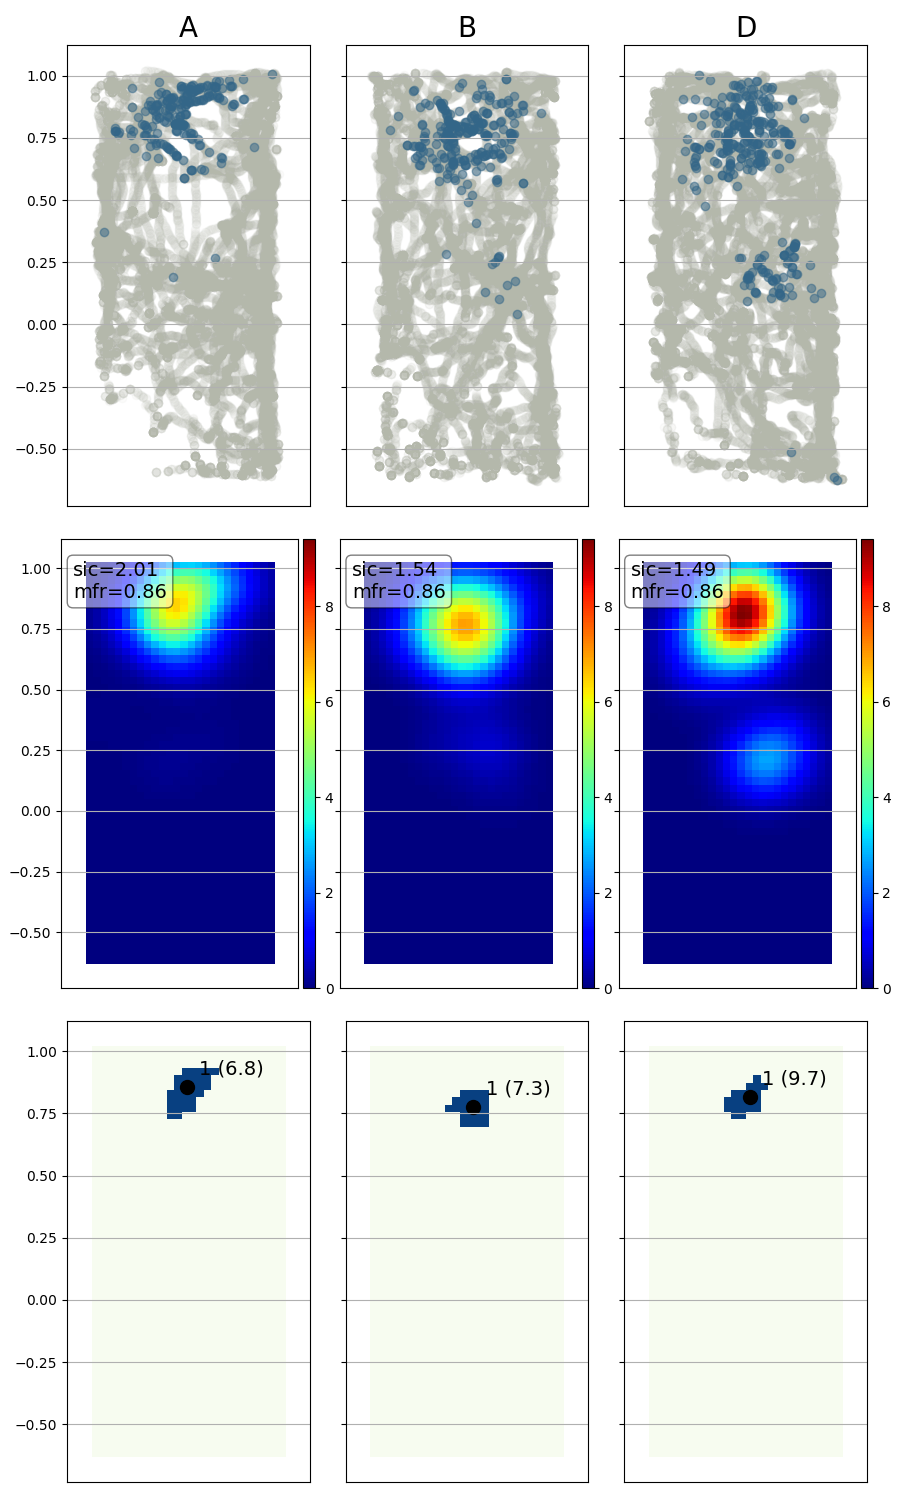

In [12]:
from IPython.display import Image

example_animal = '005363'
example_session = '2020-10-26_21-37-07'
example_unit = '2_2'
# 005363_2020-10-26_21-37-07_2_2 - multisensory
# 005363_2020-10-26_21-37-07_2_9 - multisensory

example = os.path.join(source, example_animal, example_session, 'analysis', 'bootstrapped', \
                       '%s_%s_%s.png' % (example_animal, example_session, example_unit))
Image(filename = example, width=500)



## shift histogram

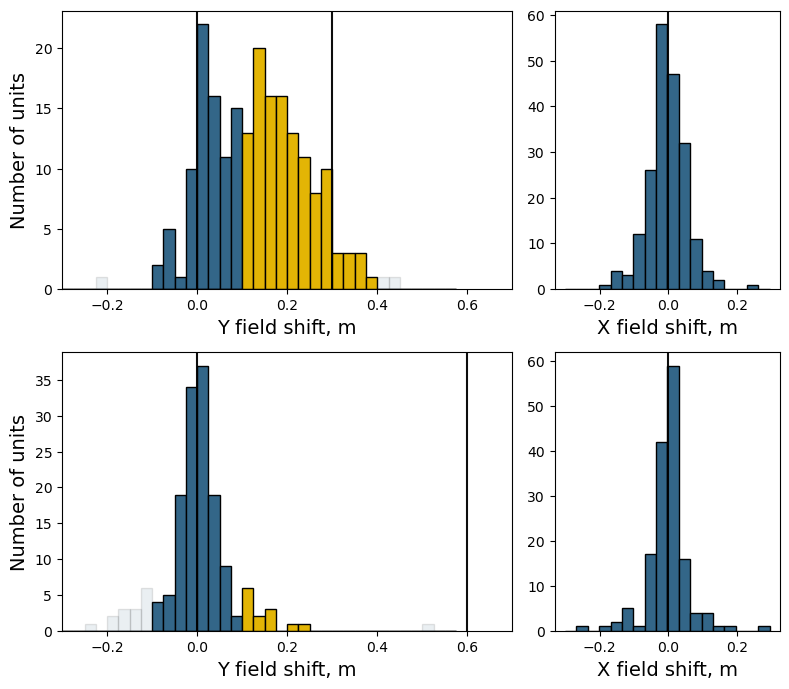

In [21]:
bins = np.arange(-0.4, 0.6, 0.025)
shifts = [0.3, 0.6]

fig, axs = plt.subplots(2, 2, gridspec_kw={
    'width_ratios': [2, 1]})
fig.set_figheight(7)
fig.set_figwidth(8)

for i, ds in enumerate([shift_A_B_short, shift_A_B_long]):
    df = ds.copy()
    df['shift'] = (-1) * (df['shift'])  # working in arena ref frame

    df = df[get_idxs_of_good_clu(df)]
    df = df[get_idxs_by_quality(df)]

    df_00 = df[(df['shift'] > grps['b'][0]) & (df['shift'] < grps['b'][1])]
    #df_15 = df[(df['shift'] > grps['h'][0]) & (df['shift'] < grps['h'][1])]
    df_30 = df[(df['shift'] > grps['v'][0]) & (df['shift'] < grps['v'][1])]
    df_   = df[(df['shift'] < grps['b'][0]) | (df['shift'] > grps['v'][1])]
    df_in = df[(df['shift'] > grps['b'][0]) & (df['shift'] < grps['v'][1])]

    # --------- Y-Axis ----------

    ax = axs[i][0]
    ax.set_xlim(-0.3, 0.7)
    ax.hist(df_00['shift'], bins=bins, color=COLORS['a'], ec='black')
    #ax.hist(df_15['shift'], bins=bins, color=COLORS['c'], ec='black')
    ax.hist(df_30['shift'], bins=bins, color=COLORS['d'], ec='black')
    ax.hist(df_['shift'],   bins=bins, color=COLORS['a'], ec='black', alpha = 0.1)

    ax.axvline(0, color='black', alpha=0.95)
    ax.axvline(shifts[i], color='black', alpha=0.95)
    ax.set_xlabel('Y field shift, m', fontsize=14)
    ax.set_ylabel('Number of units', fontsize=14)
    #ax.text(-0.28, 72, 'Boundary (%d)' % len(df_00), fontsize=14, color=COLORS['a'])
    #ax.text(-0.28, 64, 'Hybrid (%d)' % len(df_15), fontsize=14, color=COLORS['c'])
    #ax.text(-0.28, 56, 'Visual (%d)' % len(df_30), fontsize=14, color=COLORS['d'])

    ker = stats.gaussian_kde(df['shift'], bw_method=0.15)
    x_vals = np.linspace(-0.2, 0.5, 100)
    #ax.plot(x_vals, 18*ker(x_vals), color='black', alpha=0.5, lw=3, ls='--')

    # --------- X-axis -------

    ax = axs[i][1]
    ax.hist(df['COMb_x'] - df['COMa_x'], np.arange(-0.3, 0.3, 0.033), color=COLORS['a'], ec='black')
    ax.axvline(0.0, color='black', alpha=0.95)
    ax.set_xlabel('X field shift, m', fontsize=14)
    
fig.tight_layout()

filename = "3e.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

### stable and remapping fields

In [53]:
data = []

# remapping A -> B
df1 = lonely_A_B_short[lonely_A_B_short['cond'] == 'A']
df1 = df1[(df1['sic'] > 0.15) & (df1['isol_dist'] > 20) & (df1['peak_FR'] > 1.5)]

df2 = lonely_A_B_long[lonely_A_B_long['cond'] == 'A']
df2 = df2[(df2['sic'] > 0.15) & (df2['isol_dist'] > 20) & (df2['peak_FR'] > 1.5)]

df3 = shift_A_B_short[get_idxs_by_quality(shift_A_B_short)]
df4 = shift_A_B_long[get_idxs_by_quality(shift_A_B_long)]

data = [[len(df3), len(df1)], [len(df4), len(df2)]]


# remapping A+B -> dark
series = [
    (shift_A_B_short, shift_B_D_short),
    (shift_A_B_long, shift_B_D_long)
]
for dsA, dsB in series:
    # A-B field pairs
    df0 = dsA[get_idxs_by_quality(dsA)]

    # A-B-C field pairs
    df1 = dsA.merge(dsB, left_on=['animal', 'session', 'electrode', 'unit', 'field_B'], \
                right_on=['animal', 'session', 'electrode', 'unit', 'field_A'], suffixes=('_l', '_d'), how='inner')
    df1 = df1[(df1['sic_A_l'] > 0.15) & (df1['sic_B_l'] > 0.15) & (df1['sic_B_d'] > 0.15)]
    df1 = df1[df1['isol_dist_l'] > 20]
    df1 = df1[(df1['peak_FR_A_l'] > 1.5) & (df1['peak_FR_B_l'] > 1.5) & (df1['peak_FR_B_d'] > 1.5)]

    data.append( [len(df1), len(df0) - len(df1)] )
    
#data[1], data[2] = data[2], data[1]  # swap to plot shortfirst

In [54]:
#len(shift_A_B_short[get_idxs_by_quality(shift_A_B_short)])
df1 = shift_A_B_short.merge(shift_B_D_short, left_on=['animal', 'session', 'electrode', 'unit', 'field_B'], \
            right_on=['animal', 'session', 'electrode', 'unit', 'field_A'], suffixes=('_l', '_d'), how='inner')
df1 = df1[(df1['sic_A_l'] > 0.15) & (df1['sic_B_l'] > 0.15) & (df1['sic_B_d'] > 0.15)]
df1 = df1[df1['isol_dist_l'] > 20]
df1 = df1[(df1['peak_FR_A_l'] > 1.5) & (df1['peak_FR_B_l'] > 1.5) & (df1['peak_FR_B_d'] > 1.5)]
len(df1)

77

In [55]:
dff1 = shift_A_B_short[get_idxs_by_quality(shift_A_B_short)]
dff2 = shift_B_D_short[get_idxs_by_quality(shift_B_D_short)]

dfm = dff1.merge(dff2, left_on=['animal', 'session', 'electrode', 'unit', 'field_B'], \
        right_on=['animal', 'session', 'electrode', 'unit', 'field_A'], suffixes=('_l', '_d'), how='inner')
len(dfm)

76

In [58]:
len(shift_A_B_short)

291

In [57]:
data

[[187, 47], [179, 39], [77, 110], [139, 40]]

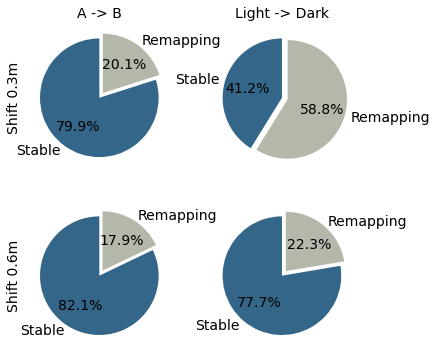

In [40]:
fig = figure(figsize=(6, 6))
labels = ['Stable', 'Remapping']
colors = [COLORS['a'], COLORS['f']]
explode = (0, 0.1)
titles = ['A -> B', 'Light -> Dark']
y_labels = ['Shift 0.3m', 'Shift 0.6m']

for i, rem_data in enumerate(data):
    ax = fig.add_subplot(2, 2, i+1)
    wedges, lbls, autopct = ax.pie(rem_data, explode=explode, colors=colors, labels=labels, \
                 autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=90)
    for lab in lbls:
        lab.set_fontsize(14)
    if i < 2:
        ax.set_title(titles[i], fontsize=14)
    if i % 2 == 0:
        ax.set_ylabel(y_labels[int(i/2)], fontsize=14)

#fig.tight_layout()
filename = "03-vSHIFT_remapping.png"
fig.savefig(os.path.join(os.path.join(paper), filename))

## Comparison with Physical shift

In [15]:
s_list_periodic_light = get_sessions_list(source, animals, 'SHIFT periodic')
s_list_periodic_dark = get_sessions_list(source, animals, 'SHIFT periodic +dark')
s_list_periodic_all = list(s_list_periodic_light) + list(s_list_periodic_dark)
s_list_single = get_sessions_list(source, animals, 'SHIFT single +dark')
s_list_all = list(s_list_single) + list(s_list_periodic_all)

p_shift = get_fields_between_epochs(source, s_list_all, 'A', 'B')

No required H5 file found for 2020-10-23_12-57-03
PF match found for 1128 fields from total 2258 A and 2247 B fields


In [16]:
df_v = shift_A_B_short.copy()
df_v['shift'] = (-1) * (df_v['shift'])
df_v = df_v[get_idxs_of_good_clu(df_v)]
df_v = df_v[get_idxs_by_quality(df_v)]

df_p = p_shift.copy()
df_p['shift'] = (-1) * (df_p['shift'] - 0.3)
df_p = df_p[get_idxs_of_good_clu(df_p)]
df_p = df_p[get_idxs_by_quality(df_p)]

In [17]:
np.median(np.array(df_v['shift']))

0.1321716442652953

(0.05617313432833271, 0.8126500238010056)

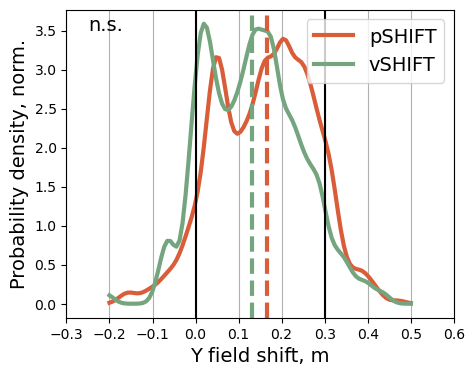

In [27]:
bins = np.arange(-0.4, 0.6, 0.025)
fig = figure(figsize=(5, 4))

ax = fig.add_subplot(111)
ax.set_xlim(-0.3, 0.6)

ker_p = stats.gaussian_kde(df_p['shift'], bw_method=0.15)
ker_v = stats.gaussian_kde(df_v['shift'], bw_method=0.15)
x_vals = np.linspace(-0.2, 0.5, 100)
ax.plot(x_vals, ker_p(x_vals), color=COLORS['b'], lw=3, ls='-', label='pSHIFT')
ax.plot(x_vals, ker_v(x_vals), color=COLORS['c'], lw=3, ls='-', label='vSHIFT')
ax.axvline(0, color='black')
ax.axvline(0.3, color='black')
ax.axvline(np.median(np.array(df_p['shift'])), color=COLORS['b'], lw=3, ls='--')
ax.axvline(np.median(np.array(df_v['shift'])), color=COLORS['c'], lw=3, ls='--')
ax.xaxis.grid()
ax.set_xlabel('Y field shift, m', fontsize=14)
ax.set_ylabel('Probability density, norm.', fontsize=14)
ax.text(-0.25, 3.5, 'n.s.', fontsize=14)
ax.legend(loc='upper right', fontsize=14)

filename = "3d.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

st, pv = scipystats.kruskal(ker_p(x_vals), ker_v(x_vals))
st, pv

In [28]:
st, pval = scipystats.kruskal(np.array(df_p['shift']), np.array(df_v['shift']))
U1, pvalm = scipystats.mannwhitneyu(np.array(df_p['shift']), np.array(df_v['shift']))
st, pval, U1, pvalm

(13.043020164392146, 0.00030441679401790205, 71233.0, 0.00030462208982460234)

In [29]:
scipystats.ks_2samp(np.array(df_p['shift']), np.array(df_v['shift']))

KstestResult(statistic=0.16226622662266227, pvalue=0.0005915057031487652, statistic_location=0.18795549182339227, statistic_sign=-1)

### Recalibration

In [30]:
animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363', '005364']

s_list_s = get_sessions_list(source, animals, 'SHIFT visual +dark')
s_list_l = get_sessions_list(source, animals, 'SHIFT visual long +dark')
#s_list_all = list(s_list_l) + list(s_list_d)

data = {}
for cond_A, cond_B in [('A', 'B'), ('A', 'D'), ('B', 'D')]:
    for i, sessions in enumerate([s_list_s, s_list_l]):
        ds = get_fields_between_epochs(source, sessions, cond_A, cond_B)
        data['%s%s_%s' % (cond_A, cond_B, 's' if i==0 else 'l')] = ds[get_idxs_by_quality(ds)]

print('Found %s sessions' % len(s_list_s))

PF match found for 284 fields from total 513 A and 527 B fields
PF match found for 288 fields from total 516 A and 527 B fields
PF match found for 279 fields from total 513 A and 495 D fields
PF match found for 289 fields from total 516 A and 524 D fields
PF match found for 281 fields from total 527 B and 495 D fields
PF match found for 275 fields from total 527 B and 524 D fields
Found 22 sessions


In [31]:
df_ABs = data['AB_s'].add_prefix('ab_')
df_BDs = data['BD_s'].add_prefix('bd_')
df_ADs = data['AD_s'].add_prefix('ad_')
df_ABl = data['AB_l'].add_prefix('ab_')
df_BDl = data['BD_l'].add_prefix('bd_')
df_ADl = data['AD_l'].add_prefix('ad_')

df_ABDs = df_ABs.merge(df_BDs, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
        right_on=['bd_animal', 'bd_session', 'bd_electrode', 'bd_unit', 'bd_field_A'], how='inner')
df_ABDs = df_ABDs.merge(df_ADs, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
        right_on=['ad_animal', 'ad_session', 'ad_electrode', 'ad_unit', 'ad_field_A'], how='inner')

df_ABDl = df_ABl.merge(df_BDl, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
        right_on=['bd_animal', 'bd_session', 'bd_electrode', 'bd_unit', 'bd_field_A'], how='inner')
df_ABDl = df_ABDl.merge(df_ADl, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
        right_on=['ad_animal', 'ad_session', 'ad_electrode', 'ad_unit', 'ad_field_A'], how='inner')

len(df_ABDs), len(df_ABDl)

(131, 133)

0.03666959087192143
6.693696747431148e-10
0.40546006424691117
0.02054252833239375


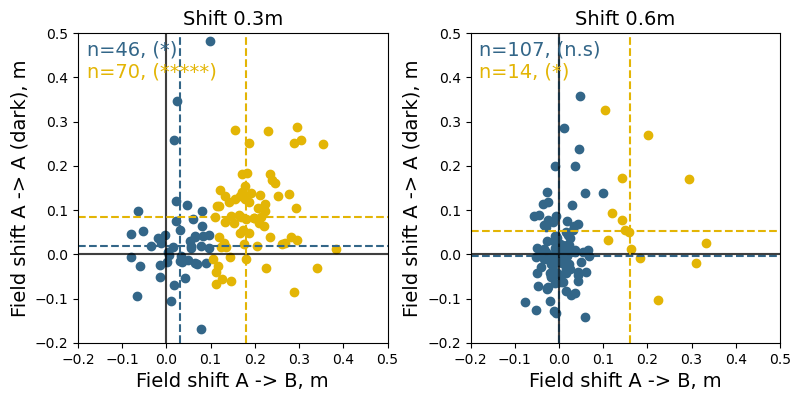

In [38]:
fig = plt.figure(figsize=(8, 6))
colors = (COLORS['a'], COLORS['d'])  # COLORS['c'], 
sts = [['*', '*****'], ['n.s', '*']]
datasets = [df_ABDs, df_ABDl]

for s, shift in enumerate([0.3, 0.6]):
    ax = fig.add_subplot(1, 2, s+1)
    
    df_m = datasets[s].copy()
    df_m['ab_shift'] = (-1) * df_m['ab_shift']
    df_00 = df_m[(df_m['ab_shift'] > grps['b'][0]) & (df_m['ab_shift'] < grps['b'][1])]
    #df_15 = df_m[(df_m['ab_shift'] > grps['h'][0]) & (df_m['ab_shift'] < grps['h'][1])]
    df_30 = df_m[(df_m['ab_shift'] > grps['v'][0]) & (df_m['ab_shift'] < grps['v'][1])]

    all_x = np.concatenate([df_00['ab_shift'], df_30['ab_shift']])  # df_15['ab_shift'], 
    all_y = np.concatenate([df_00['ad_shift'], df_30['ad_shift']])  # df_15['ad_shift'], 

    slope, intercept, r, p, se = stats.linregress(all_x, all_y)

    for i, ds in enumerate([df_00, df_30]):  # df_15, 
        x_vals = ds['ab_shift']
        y_vals = (-1) * ds['ad_shift']
        st, pv = stats.kruskal(x_vals, y_vals)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals, y_vals)
        res = stats.ttest_1samp(y_vals, 0)
        print(res.pvalue)

        #ax = fig.add_subplot(1, 3, i+1)
        ax.scatter(x_vals, y_vals, color=colors[i])
        #ax.plot(x_vals, intercept + slope*x_vals, color=colors[i])
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.2, 0.5)
        ax.axvline(0, color='black', alpha=0.5)
        ax.axhline(0, color='black', alpha=0.5)
        ax.axvline(np.median(x_vals), ls='--', color=colors[i])
        ax.axhline(np.median(y_vals), ls='--', color=colors[i])
        ax.set_aspect('equal')
        #ax.set_title('Shift 0.6m. slope=%.2f, p=%.4f' % (slope, p), fontsize=14)
        ax.set_title('Shift %sm' % shift, fontsize=14)
        ax.text(-0.18, 0.45 - i*0.05, 'n=%s, (%s)' % (len(y_vals), sts[s][i]), fontsize=14, color=colors[i])
        #ax.text(-0.18, 0.45 - i*0.05, 'n=%s, p=%.4f' % (len(y_vals), pv), fontsize=14, color=colors[i])
        ax.set_xlabel('Field shift A -> B, m', fontsize=14)
        ax.set_ylabel('Field shift A -> A (dark), m', fontsize=14)
        ax.grid()
    
fig.tight_layout()
filename = "3g_2.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

## Population: dynamics LIGHT vs DARK

In [11]:
def plot_hist(ax, data, bins, x_lim_l, x_lim_r, plot_median=True):
    ax.set_xlim(x_lim_l, x_lim_r)
    ax.hist(data, bins=bins, color=COLORS['a'], ec='black')
    ax.axvline(0, color=COLORS['b'])
    ax.axvline(-0.3, color=COLORS['b'])

    if not plot_median:
        return
    
    tt_stat_CD, tt_pval_CD = stats.ttest_1samp(data, 0.0)
    hist_max = np.histogram(data, bins=bins)[0].max()

    ax.axvline(np.median(data), ls='--', color=COLORS['b'])
    ax.text(x_lim_l + 0.05, 0.9 * np.histogram(data, bins=bins)[0].max(), 'n = %d' % len(data), fontsize=14)
    ax.text(x_lim_l + 0.05, 0.8 * np.histogram(data, bins=bins)[0].max(), 'med = %.2f' % np.median(data), fontsize=14)
    ax.text(x_lim_l + 0.05, 0.7 * hist_max, 't(%s) = %.3f' % (len(data), tt_stat_CD), fontsize=14)
    ax.text(x_lim_l + 0.05, 0.6 * hist_max, 'p-val = %.3f' % tt_pval_CD, fontsize=14)

Text(-0.52, 0.4, 'd')

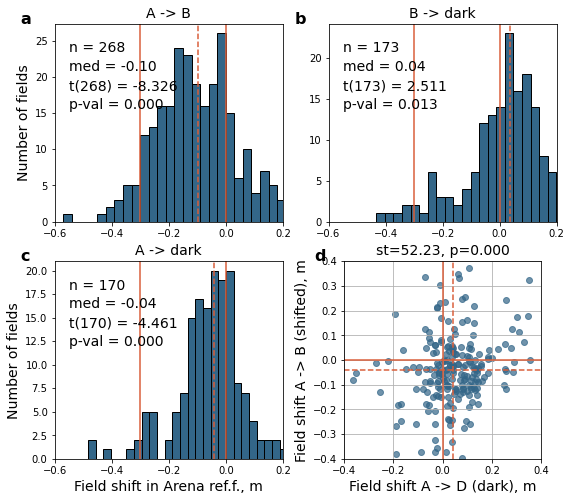

In [12]:
gspec = gridspec.GridSpec(ncols=2, nrows=2)
fig = figure(figsize=(9, 8))
x_lim_l = -0.6
x_lim_r =  0.2
bins = np.arange(-0.6, 0.4, 0.03)

# A - B in light (should be 0.15), Ad - Bd in dark (should be 0.3)
data = np.array(shift_A_B_short[get_idxs_by_quality(shift_A_B_short)]['shift'])
ax = fig.add_subplot(gspec[0, 0])
ax.set_ylabel('Number of fields', fontsize=14)
ax.set_title("A -> B", fontsize=14)
plot_hist(ax, data, bins, x_lim_l, x_lim_r)
ax.text(ax.get_xlim()[0] - 0.15 * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[1], 'a', fontsize=16, fontweight='bold')


# B - D light/dark - should be 0.15 but actually ~0
bins = 30
data = np.array(shift_B_D_short[get_idxs_by_quality(shift_B_D_short)]['shift'])
ax = fig.add_subplot(gspec[0, 1])
ax.set_title("B -> dark", fontsize=14)
plot_hist(ax, data, bins, x_lim_l, x_lim_r)
ax.text(ax.get_xlim()[0] - 0.15 * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[1], 'b', fontsize=16, fontweight='bold')


# A - D light/dark (should be 0?) but actually < 0!
ax = fig.add_subplot(gspec[1, 0])
ax.set_ylabel('Number of fields', fontsize=14)
ax.set_title("A -> dark", fontsize=14)
plot_hist(ax, np.array(shift_A_D_short[get_idxs_by_quality(shift_A_D_short)]['shift']), 35, x_lim_l, x_lim_r)
ax.set_xlabel('Field shift in Arena ref.f., m', fontsize=14)
ax.text(ax.get_xlim()[0] - 0.15 * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[1], 'c', fontsize=16, fontweight='bold')


# scatter
# A-B-C field pairs
df_AB  = shift_A_B_short.add_prefix('ab_')
df_AD  = shift_A_D_short.add_prefix('ad_')
df_BD  = shift_B_D_short.add_prefix('bd_')

df1 = df_AB.merge(df_AD, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
        right_on=['ad_animal', 'ad_session', 'ad_electrode', 'ad_unit', 'ad_field_A'], how='inner')
df1 = df1.merge(df_BD, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
        right_on=['bd_animal', 'bd_session', 'bd_electrode', 'bd_unit', 'bd_field_A'], how='inner')

#df1 = shift_A_B_short.merge(shift_A_D_short, left_on=['animal', 'session', 'electrode', 'unit', 'field_A'], \
#        right_on=['animal', 'session', 'electrode', 'unit', 'field_A'], suffixes=('_l', '_d'), how='inner')
#df1 = df1.merge(shift_A_D_short, left_on=['animal', 'session', 'electrode', 'unit', 'field_A'], \
#        right_on=['animal', 'session', 'electrode', 'unit', 'field_A'], suffixes=('_l', '_d'), how='inner')

#df1 = df1[(df1['sic_A_l'] > 0.15) & (df1['sic_B_l'] > 0.15) & (df1['sic_B_d'] > 0.15)]
#df1 = df1[df1['isol_dist_l'] > 20]
#df1 = df1[(df1['peak_FR_A_l'] > 1.5) & (df1['peak_FR_B_l'] > 1.5) & (df1['peak_FR_B_d'] > 1.5)]
#match_both, match_A_D, match_B_D, match_none = get_matching_fields(shift_A_B_short, shift_B_D_short, shift_A_D_short)

shift_AB = (-1) * df1['ad_shift']
shift_AD = (-1) * df1['bd_shift']

ax = fig.add_subplot(gspec[1, 1])
#ax.set_xlim(x_lim_l, x_lim_r)
#ax.set_ylim(x_lim_l, x_lim_r)
ax.set_xlim(-0.4, 0.4)
ax.set_ylim(-0.4, 0.4)
ax.set_aspect('equal')
ax.grid()
ax.scatter(shift_AB, shift_AD, alpha=0.7, color=COLORS['a'])
#ax.scatter(shift_ABp, shift_ADp, alpha=0.7, color=COLORS['a'])
ax.axhline(0.0, color=COLORS['b'])
ax.axvline(0.0, color=COLORS['b'])
line = np.linspace(-1.0, 1.0, 10)
#ax.plot(line, line, color=COLORS['b'], label='no change line')
slope, intercept, r_value, p_value, std_err = stats.linregress(shift_AB, shift_AD)
st, pv = stats.kruskal(shift_AB, shift_AD)

#ax.plot(shift_AB, intercept + slope*shift_AB, ls='--', color=COLORS['a'])
#ax.plot([-0.6, 0.6], [-0.6, 0.6], ls='--', color=COLORS['b'])

ax.axvline(np.median(shift_AB), color=COLORS['b'], ls='--')
ax.axhline(np.median(shift_AD), color=COLORS['b'], ls='--')
ax.set_title('st=%.2f, p=%.3f' % (st, pv), fontsize=14)

ax.set_xlabel('Field shift A -> D (dark), m', fontsize=14)
ax.set_ylabel('Field shift A -> B (shifted), m', fontsize=14)
ax.text(ax.get_xlim()[0] - 0.15 * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[1], 'd', fontsize=16, fontweight='bold')


#fig.tight_layout()
#filename = "03-vSHIFT_shifts_in_diff_conditions_visual.png"
#fig.savefig(os.path.join(os.path.join(paper), filename))